In [9]:
import glob
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.colors import LogNorm
import numpy as np
import cv2
import pandas as pd

from astropy.io import fits 
import sunpy.visualization.colormaps as cm
from matplotlib.path import Path
import sunpy.map
from sunpy.map.header_helper import make_heliographic_header
arcsec_symbol = u"\u2033"

In [10]:
def degree_formatter(x, pos):
    return f'{int(x)}°'

def arcsec_formatter(x, pos):
    return f'{int(x)}"'

### Load the image and perform each processesm

In [12]:
path = "/home/joseph/DL/DATASET/AIA_1200UT/*.*"
filename = np.sort(glob.glob(path))
image_index = 0
for file in filename[1235:1236]:
    aia = fits.open(file)
    full_disc = aia[1].data
    radians = np.linspace(0, 2*np.pi)
    centre = aia[1].header['CRPIX2']
    rsun = aia[1].header['R_SUN']/4                                                       
    c = centre + rsun*np.cos(radians)
    r = centre + rsun*np.sin(radians)
    xycrop = np.vstack((c,r)).T

    nr, nc = full_disc.shape
    ygrid, xgrid = np.mgrid[:nr, :nc]
    xypix = np.vstack((xgrid.ravel(), ygrid.ravel())).T
    
    # construct a Path from the vertices
    pth = Path(xycrop, closed=False)
    # test which pixels fall within the path
    mask = pth.contains_points(xypix)
    mask = mask.reshape(full_disc.shape)
    
    mask_copy = mask.copy()
    full_disc1 = full_disc.copy()
    full_disc1[~mask_copy] = np.nan

    row = np.isnan(full_disc1).all(axis=1)
    coll = np.isnan(full_disc1).all(axis=0)
    
    cropped_full_disc = full_disc1[~row][:,~coll]

    # Normalizing the image from the logrithmic scale
    log_full_disc_scale = np.log(cropped_full_disc)
    
    # Normalization, with the consideration of the NAN values
    non_nan_log_full_disc_scale = log_full_disc_scale[~np.isnan(log_full_disc_scale)]
    mini = np.min(non_nan_log_full_disc_scale)
    maxi = np.max(non_nan_log_full_disc_scale)
    stdd = np.std(non_nan_log_full_disc_scale)
    meann = np.mean(non_nan_log_full_disc_scale)

    standardized_full_disc = ((log_full_disc_scale - meann)/stdd)
    
    f_name = file[-23:-15]
    aia_map = sunpy.map.Map(file)
    shape = (1440, 2880)
    carr_header = make_heliographic_header(aia_map.date,
                                           aia_map.observer_coordinate,
                                           shape, frame='stonyhurst',)
    outmap = aia_map.reproject_to(carr_header)
    cc = outmap.data
    flip = cc[::-1,:]


In [13]:
nan_mask = np.isnan(flip)
center_row = flip.shape[0] // 2
# Observe the First and The Last non-Nan at the intercept (center row)
center_non_nan_cols = np.where(~nan_mask[center_row])[0]
# Let the range of the new image be from the begining of the first non-Nan : to the Last non-Nan
if len(center_non_nan_cols) > 0:
    start_col = center_non_nan_cols[0]
    end_col = center_non_nan_cols[-1] + 1  # Note that: Negative indexing means the Last Value

    # Find the first and last non-NaN in the (ALL THE COLUMN) columns of the bounding box
    rows_with_nan_in_box = np.any(~nan_mask[:, start_col:end_col], axis=1)
    start_row = np.argmax(rows_with_nan_in_box)
    end_row = len(rows_with_nan_in_box) - np.argmax(rows_with_nan_in_box[::-1])

    # Crop the image to the bounding box
    cropped_image = flip[start_row:end_row, start_col:end_col]
else:
    cropped_image = np.array([])  # If there are no non-NaN values in the center row

cropped_image_copy = cropped_image.copy()
nan_mask = np.isnan(cropped_image_copy)
cropped_image_copy[nan_mask] = np.interp(np.flatnonzero(nan_mask), np.flatnonzero(~nan_mask), cropped_image_copy[~nan_mask])

heinemann_thresh = 0.29* np.median(cropped_image_copy) + 11.53
heinemann_binary = cropped_image_copy > heinemann_thresh
heinemann_binary_p = heinemann_binary < 1


# Standardizing the image from the logrithmic scale
log_i = np.log(cropped_image_copy)

# Remove NAN Effects
non_nan_log_i = log_i[~np.isnan(log_i)]
mini = np.min(non_nan_log_i)
maxi = np.max(non_nan_log_i)
stdd = np.std(non_nan_log_i)
meann = np.mean(non_nan_log_i)
std_log_image = ((log_i - meann)/stdd)
    


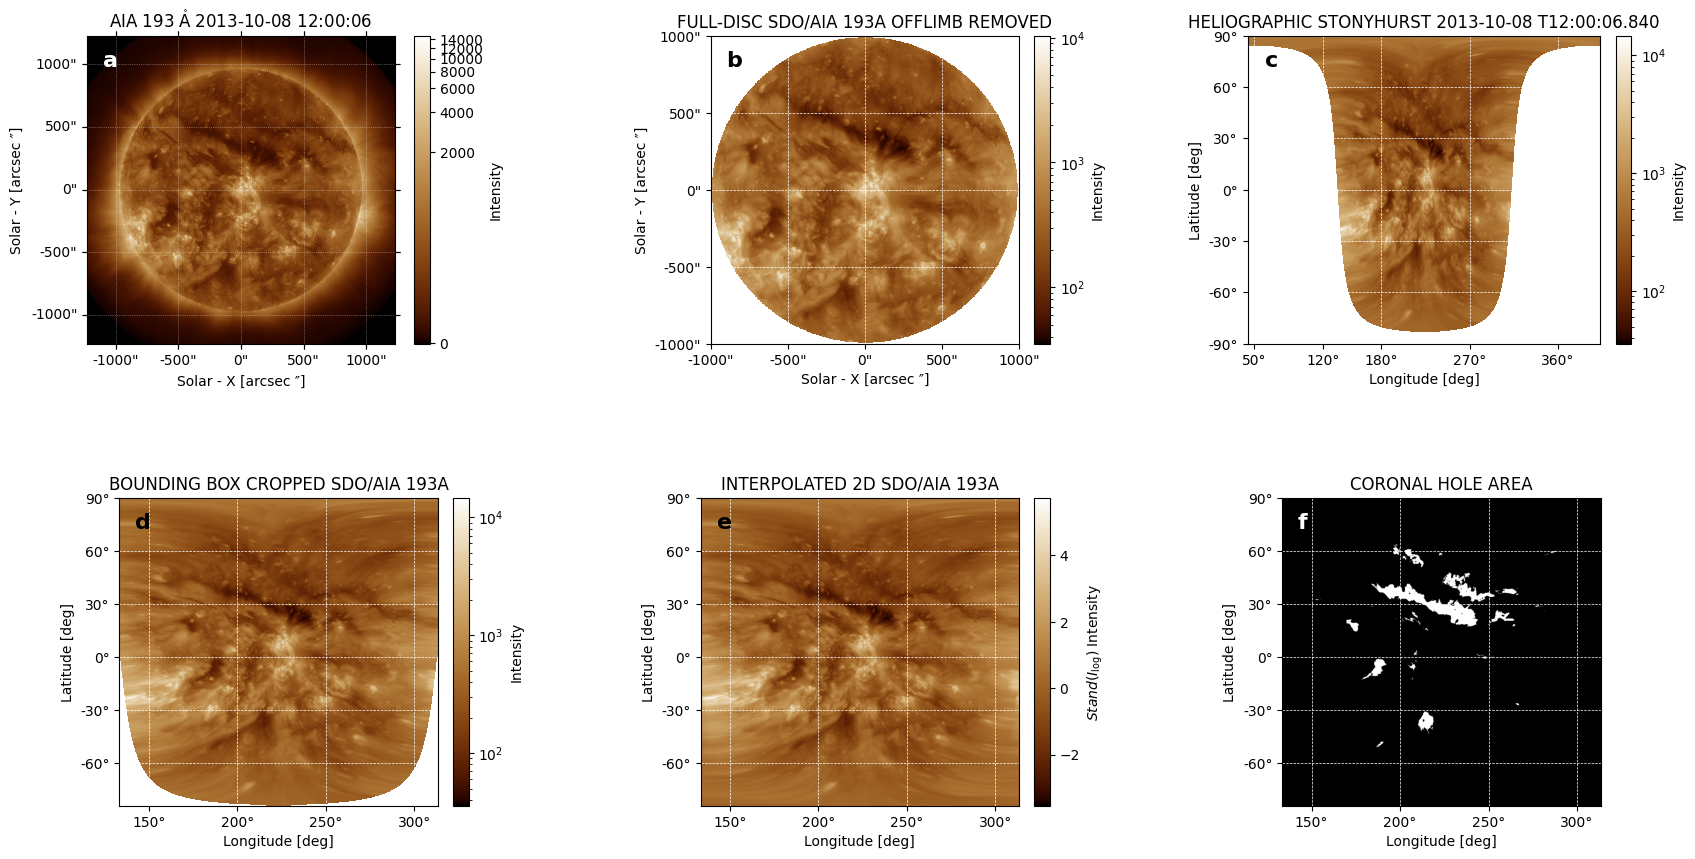

In [14]:
fig = plt.figure(figsize=(20,10))

cax_0 = fig.add_subplot(231, projection=aia_map)
c0 = aia_map.plot()
c_11 = plt.colorbar()
c_11.set_label('Intensity')
cax_0.set_xlabel(f'Solar - X [arcsec {arcsec_symbol}]')
cax_0.set_ylabel(f'Solar - Y [arcsec {arcsec_symbol}]')

cax_1= fig.add_subplot(232)
x_1 = cax_1.imshow(cropped_full_disc, cmap='sdoaia193', origin='lower', norm=LogNorm(), extent=[-1000,1000, -1000,1000])
cax_1.set_title("FULL-DISC SDO/AIA 193A OFFLIMB REMOVED")
cax_1.set_xlabel(f'Solar - X [arcsec {arcsec_symbol}]')
cax_1.set_ylabel(f'Solar - Y [arcsec {arcsec_symbol}]')
cax_1.set_xticks(np.arange(-1000, 1001, 500)) 
cax_1.set_yticks(np.arange(-1000, 1001, 500))
cax_1.xaxis.set_major_formatter(ticker.FuncFormatter(arcsec_formatter))
cax_1.yaxis.set_major_formatter(ticker.FuncFormatter(arcsec_formatter))
cax_1.grid(True, which='both', color='white', linestyle='--', linewidth=0.5)
cax_1.grid('on')
cax_1.axis('on')
cbar1 = plt.colorbar(x_1, ax=cax_1,fraction=0.05, pad=0.04)
cbar1.set_label('Intensity')

# cax_2 = fig.add_subplot(233, projection=outmap)
# c1 = outmap.plot(norm=LogNorm())
# cax_2.set_aspect('auto')
# cbar2 = plt.colorbar(c1, ax=cax_2, fraction=0.05, pad=0.04)
# cbar2.set_label('Intensity')

x_right = (179.9375 + aia[1].header["CRLN_OBS"])
x_left = (-179.9375 + aia[1].header["CRLN_OBS"])
cax_2 = fig.add_subplot(233)
c1= cax_2.imshow(cc, origin='lower', cmap='sdoaia193', norm=LogNorm(), extent=[x_left, x_right, -89.9375, 89.9375])
cax_2.set_title("HELIOGRAPHIC STONYHURST 2013-10-08 T12:00:06.840")
cax_2.set_xlabel(f'Longitude [deg]')
cax_2.set_ylabel(f'Latitude [deg]')
cax_2.grid(True, which='both', color='white', linestyle='--', linewidth=0.5)
# cax_2.set_xticks(x_left, 30, x_center,x_right )
cax_2.set_xticks(np.arange(x_left, x_right, x_left*2+13)) 
xticks = [50, 120, 180, 270, 360, 10, 20, 30, 40]
cax_2.set_xticks(xticks)
cax_2.set_xlim(x_left, x_right)
cax_2.set_yticks(np.arange(-90, 91, 30))
cax_2.xaxis.set_major_formatter(ticker.FuncFormatter(degree_formatter))
cax_2.yaxis.set_major_formatter(ticker.FuncFormatter(degree_formatter))

cax_2.grid('on')
cax_2.axis('on')
cax_2.set_aspect('auto')
cbar2 = plt.colorbar(c1, ax=cax_2, fraction=0.05, pad=0.04)
cbar2.set_label('Intensity')

cax_3 = fig.add_subplot(234)
x_3 = cax_3.imshow(cropped_image, cmap='sdoaia193',norm=LogNorm(), extent=[x_left+90, x_right-90, -84,90])
cax_3.set_title("BOUNDING BOX CROPPED SDO/AIA 193A")
cax_3.set_xlabel(f'Longitude [deg]')
cax_3.set_ylabel(f'Latitude [deg]')
cax_3.grid(True, which='both', color='white', linestyle='--', linewidth=0.5)
# cax_3.set_xticks(np.arange(-90, 91, 30)) 
cax_3.set_yticks(np.arange(90, -84, -30))
cax_3.xaxis.set_major_formatter(ticker.FuncFormatter(degree_formatter))
cax_3.yaxis.set_major_formatter(ticker.FuncFormatter(degree_formatter))

# cax_3.axvline(x=(aia[1].header["CRLN_OBS"])-7.5, ymin=0, ymax=1, color='r', linestyle='-', linewidth=2)
# cax_3.axvline(x= (aia[1].header["CRLN_OBS"])+7.5, ymin=0, ymax=1, color='r', linestyle='-', linewidth=2)
cax_3.grid('on')
cax_3.axis('on')
cbar3 = plt.colorbar(x_3, ax=cax_3, fraction=0.05, pad=0.04)
cbar3.set_label('Intensity')

cax_4 = fig.add_subplot(235) 
x_4 = cax_4.imshow(std_log_image, cmap='sdoaia193', extent=[x_left+90, x_right-90, -84,90])
cax_4.set_title("INTERPOLATED 2D SDO/AIA 193A")
cax_4.set_xlabel(f'Longitude [deg]')
cax_4.set_ylabel(f'Latitude [deg]')
cax_4.grid(True, which='both', color='white', linestyle='--', linewidth=0.5)
# cax_4.set_xticks(np.arange(-90, 91, 30)) 
cax_4.set_yticks(np.arange(90, -84, -30)) #set_yticks(np.arange(-84, 91, 30))
cax_4.xaxis.set_major_formatter(ticker.FuncFormatter(degree_formatter))
cax_4.yaxis.set_major_formatter(ticker.FuncFormatter(degree_formatter))

# cax_4.axvline(x=(aia[1].header["CRLN_OBS"])-7.5, ymin=0, ymax=1, color='r', linestyle='-', linewidth=2)
# cax_4.axvline(x= (aia[1].header["CRLN_OBS"])+7.5, ymin=0, ymax=1, color='r', linestyle='-', linewidth=2)
cax_4.grid('on')
cax_4.axis('on')
cbar4 = plt.colorbar(x_4, ax=cax_4, fraction=0.05, pad=0.04)
cbar4.set_label(r'$Stand(I_{\mathrm{log}})$ Intensity')

cax_5 = fig.add_subplot(236)
x_5 = cax_5.imshow(heinemann_binary_p, cmap = 'gray', extent=[x_left+90, x_right-90, -84,90])
cax_5.set_title("CORONAL HOLE AREA")
cax_5.set_xlabel(f'Longitude [deg]')
cax_5.set_ylabel(f'Latitude [deg]')
cax_5.grid(True, which='both', color='white', linestyle='--', linewidth=0.5)
# cax_5.set_xticks(np.arange(-90, 91, 30)) 
cax_5.set_yticks(np.arange(90, -84, -30)) 

cax_5.xaxis.set_major_formatter(ticker.FuncFormatter(degree_formatter))
cax_5.yaxis.set_major_formatter(ticker.FuncFormatter(degree_formatter))

# cax_5.axvline(x=(aia[1].header["CRLN_OBS"])-7.5, ymin=0, ymax=1, color='r', linestyle='-', linewidth=2)
# cax_5.axvline(x= (aia[1].header["CRLN_OBS"])+7.5, ymin=0, ymax=1, color='r', linestyle='-', linewidth=2)
cax_5.grid('on')
cax_5.axis('on')
# cbar5 = plt.colorbar(x_5, ax=cax_5, fraction=0.05, pad=0.04)
# cbar5.set_label('Intensity')

labels = ['a', 'b', 'c', 'd', 'e', 'f']
colors = ['white', 'black', 'black', 'black', 'black', 'white']
for i, (ax, label, color) in enumerate(zip([cax_0, cax_1, cax_2, cax_3, cax_4, cax_5], labels, colors)):
    ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', color=color)


# labels = ['1a', '1b', '1c', '1d', '1e', '1f']
#   # Colors for each label
# for i, (ax, label, color) in enumerate(zip([ax1, ax2, ax3, ax4, ax5, ax6], labels, colors)):
#     ax.text(0.05, 0.95, label, transform=ax.transAxes, fontsize=16, fontweight='bold', va='top', color=color)

plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.savefig("Full_processing.png")